In [66]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.set_option('display.max_columns', None)

## 1 Load dataset

In [26]:
df = pd.read_csv('../data/clv.csv')
df.shape

(12361, 19)

In [27]:
## Load dataset and create new dataset with unique ContactId

df_user = pd.DataFrame(df['ContactId'].unique(), columns=['ContactId'])
df_user.head()

,ContactId
0,CNTID_1000
1,CNTID_1003
2,CNTID_1004
3,CNTID_1006
4,CNTID_1008


In [28]:
## Change data type of date: object -> date

for col in ['DateOfBirth', 'CreatedOn', 'CreatedOn_loyalty', 'PurchasedOn']:
    df[col] = pd.to_datetime(df[col])

## 2 Feature Engineering

Create new features:
- Age
- Tenure: Days between first and last purchase
- Days since first purchase
- LoyaltyDuration = (Latest purchase date of each customer) - (loyalty-participate date)\
    => Failed cause most of loyalty profiles were created after the last purchase
- Recency: Days since last purchase
- Frequency: Total number of purchases
- Monetary: Total cost of purchases

*For Recency, Frequecy and Monetary, we will apply some clustering algorithm to assign scores respectively*


In [29]:
df.head()

,ContactId,DateOfBirth,Gender,City,State,CreatedOn,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,CreatedOn_loyalty,PurchaseId,ProductId,PurchasedOn,TotalPrice,ReviewRating
0,CNTID_1000,1986-05-08,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1000,ProdID_1007,2019-01-20,2516,4.8
1,CNTID_1000,1986-05-08,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1001,ProdID_1032,2018-11-04,2597,4.8
2,CNTID_1000,1986-05-08,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1002,ProdID_1012,2018-10-10,2589,4.8
3,CNTID_1000,1986-05-08,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1003,ProdID_1038,2018-03-07,144,4.8
4,CNTID_1003,2006-09-03,Male,Nashville,Tennessee,2019-01-17,medium,No,61917.706144,Teacher,medium,116,No,2017-07-03,OPID_1005,ProdID_1047,2017-08-09,47,5.0


### 2.1 Age, Tenure, Days since first purchase

In [30]:
df['Age'] = (df.PurchasedOn.max() - df.DateOfBirth)//pd.Timedelta(days=365.25)
df.drop('DateOfBirth', axis=1, inplace=True)

last_purs = df.groupby('ContactId').PurchasedOn.max().reset_index()
first_purs = df.groupby('ContactId').PurchasedOn.min().reset_index()
first_purs['Tenure'] = (last_purs.PurchasedOn - first_purs.PurchasedOn)//pd.Timedelta(days=1) + 1
first_purs['Days_since_first_purs'] = (df.PurchasedOn.max() - first_purs.PurchasedOn)//pd.Timedelta(days=1) + 1

df = pd.merge(df, first_purs[['ContactId', 'Tenure']], on='ContactId')
df = pd.merge(df, first_purs[['ContactId', 'Days_since_first_purs']], on='ContactId')

# loyalty = df.groupby('ContactId').PurchasedOn.max().reset_index()
# loyalty = pd.merge(loyalty, df[['ContactId', 'CreatedOn_loyalty']], on='ContactId')
# loyalty['Loyalty'] = (loyalty.PurchasedOn - loyalty.CreatedOn_loyalty)//pd.Timedelta(days=1)

df.head()

,ContactId,Gender,City,State,CreatedOn,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,CreatedOn_loyalty,PurchaseId,ProductId,PurchasedOn,TotalPrice,ReviewRating,Age,Tenure,Days_since_first_purs
0,CNTID_1000,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1000,ProdID_1007,2019-01-20,2516,4.8,32,320,337
1,CNTID_1000,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1001,ProdID_1032,2018-11-04,2597,4.8,32,320,337
2,CNTID_1000,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1002,ProdID_1012,2018-10-10,2589,4.8,32,320,337
3,CNTID_1000,Female,Fairfield,California,2017-03-14,high,Yes,256414.112709,Software Engineer,high,293,Yes,2018-10-19,OPID_1003,ProdID_1038,2018-03-07,144,4.8,32,320,337
4,CNTID_1003,Male,Nashville,Tennessee,2019-01-17,medium,No,61917.706144,Teacher,medium,116,No,2017-07-03,OPID_1005,ProdID_1047,2017-08-09,47,5.0,12,1,547


### 2.2 Recency

For each customers, compute Recency score (inactive days) = Latest date of dataset - latest purchase date of customers. After having no. of inactive days for each customer, we will apply several clustering algorithm to assign customers a recency score.


In [31]:
import datetime as dt

df_inactive = df.groupby('ContactId').PurchasedOn.max().reset_index()
df_inactive.PurchasedOn = pd.to_datetime(df_inactive.PurchasedOn)
df_inactive['Recency'] = (df_inactive.PurchasedOn.max() - df_inactive.PurchasedOn).dt.days
df_inactive.head()

,ContactId,PurchasedOn,Recency
0,CNTID_1000,2019-01-20,17
1,CNTID_1003,2017-08-09,546
2,CNTID_1004,2018-07-22,199
3,CNTID_1006,2019-01-13,24
4,CNTID_1008,2019-01-22,15


In [32]:
df_user = df_user.merge(df_inactive.drop('PurchasedOn', axis=1), on='ContactId')
df_user.head()

,ContactId,Recency
0,CNTID_1000,17
1,CNTID_1003,546
2,CNTID_1004,199
3,CNTID_1006,24
4,CNTID_1008,15


We will apply KMeans, DBSCAN and Gaussian Mixture to assign scores

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

In [34]:
scaler = StandardScaler()
df_recency = scaler.fit_transform(df_user[['Recency']])
df_recency

array([[-0.69332178],
       [ 2.12935551],
       [ 0.27780727],
       ...,
       [ 0.11239518],
       [-0.72000115],
       [ 0.2297844 ]])

In [35]:
## Training function

def train_kmeans(clusters, df, target_columns, metric):
    scaler = StandardScaler()
    df = scaler.fit_transform(df[[target_columns]])
    
    scores = {}
    
    for k in clusters:
        
        model = KMeans(n_clusters=k, random_state=29)
        y_pred = model.fit_predict(df)
        if metric == "Silhouette score":
            scores['n_clusters = %s' % k] = silhouette_score(df, y_pred)
        else:
            scores['n_clusters = %s' % k] = model.inertia_
        
        # # Print the number of instances in each class
        # label_counts = Counter(y_pred)
        # for label, count in label_counts.items():
        #     print(f"Class {label}: {count} instances")
        # print('----------------')
    plt.plot(clusters, scores.values())
    plt.xlabel('Number of clusters')
    plt.ylabel(metric)

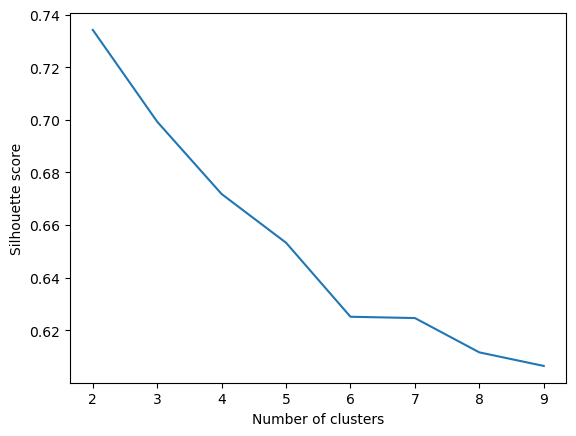

In [19]:
clusters = np.arange(2,10)

train_kmeans(clusters, df_user, 'Recency', 'Silhouette score')

In [19]:
from sklearn.cluster import DBSCAN

scores = {}
min_samples = [20,25,30,35]
params = {'eps':0.05, 'min_samples':10}

for k in min_samples:
    params['min_samples'] = k
    model = DBSCAN().set_params(**params)
    y_pred = model.fit_predict(df_recency)
    scores['min_samples = %s' % k] = silhouette_score(df_recency, y_pred)
    
scores

{'min_samples = 20': 0.6232799773154936,
 'min_samples = 25': 0.572705439917893,
 'min_samples = 30': 0.5407442099953417,
 'min_samples = 35': 0.5305947777465261}

In [20]:
from sklearn.mixture import GaussianMixture

scores = {}
clusters = np.arange(2,10)

for k in clusters:
    model = GaussianMixture(n_components=k)
    y_pred = model.fit_predict(df_recency)
    scores['n_clusters = %s' % k] = silhouette_score(df_recency, y_pred)
scores

{'n_clusters = 2': 0.5197527579486787,
 'n_clusters = 3': 0.4219705618209627,
 'n_clusters = 4': 0.4266248631073368,
 'n_clusters = 5': 0.44220307131423653,
 'n_clusters = 6': 0.4511392489391392,
 'n_clusters = 7': 0.4653349515334824,
 'n_clusters = 8': 0.47811705331715776,
 'n_clusters = 9': 0.4746034863028263}

Between the clusterers, the Kmeans tended to outperform the rest. Therefore, we will choose it to compute Frequency and Monetary scores. Let's look at the vary of inertia according to number of clusters.

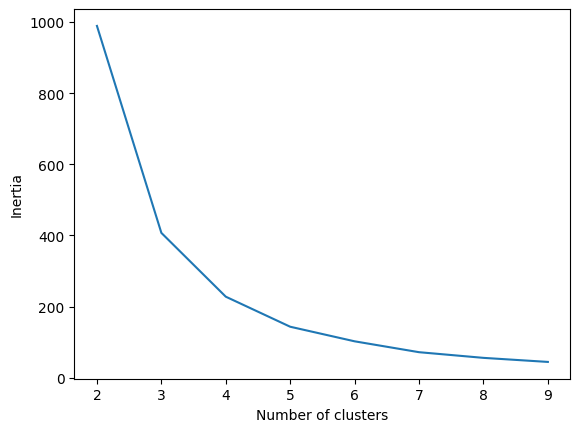

In [29]:
clusters = np.arange(2,10)

train_kmeans(clusters, df_user, 'Recency', 'Inertia')

As we can see, at 4 clusters the silhouette score was not too low, and the inertia from 5 clusters onwards did not decrease significantly. Therefore, we will choose 4 clusters for assigning Recency score.

In [36]:
kmeans = KMeans(n_clusters=4, random_state=29)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.labels_
df_user.head()

,ContactId,Recency,RecencyCluster
0,CNTID_1000,17,0
1,CNTID_1003,546,2
2,CNTID_1004,199,3
3,CNTID_1006,24,0
4,CNTID_1008,15,0


The scores were assigned randomly and did not follow any rules. We will reassign by sorting recency ascendingly, then the score increased respectively.

In [37]:
def assign_score(df, feature, feature_cluster, ascending=True):
    sorted_feature = df.groupby(feature_cluster)[feature].mean().sort_values(ascending=ascending)
    
    for i in range(len(sorted_feature)):
        df.loc[df[feature_cluster] == sorted_feature.index[i], 'new_%s' % feature_cluster] = str(i)
    df.drop(feature_cluster, axis=1, inplace=True)
    return df

In [38]:
df_user = assign_score(df_user, 'Recency', 'RecencyCluster', ascending=False)
df_user.head()

,ContactId,Recency,new_RecencyCluster
0,CNTID_1000,17,3
1,CNTID_1003,546,0
2,CNTID_1004,199,2
3,CNTID_1006,24,3
4,CNTID_1008,15,3


### 1.2 Frequency

Frequency is computed by number of purchased in determined period

In [39]:
df_freq = df.groupby('ContactId').PurchaseId.count().reset_index()
df_user = pd.merge(df_user, df_freq, on='ContactId')
df_user.columns.values[3] = 'Frequency'
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency
0,CNTID_1000,17,3,4
1,CNTID_1003,546,0,1
2,CNTID_1004,199,2,1
3,CNTID_1006,24,3,2
4,CNTID_1008,15,3,3


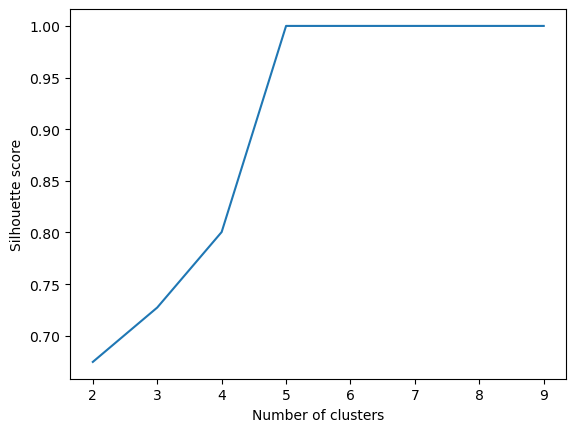

In [25]:
clusters = np.arange(2,10)

train_kmeans(clusters, df_user, 'PurchaseId', 'Silhouette score')

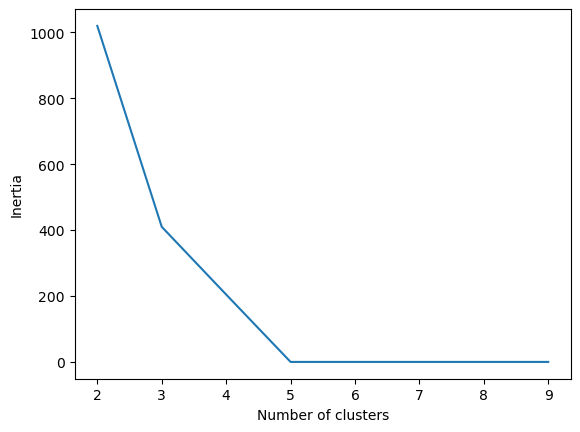

In [26]:
train_kmeans(clusters, df_user, 'PurchaseId', 'Inertia')

In [40]:
kmeans = KMeans(n_clusters=4, random_state=29)
kmeans.fit(df_user[['PurchaseId']])
df_user['FrequencyCluster'] = kmeans.labels_
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency,FrequencyCluster
0,CNTID_1000,17,3,4,1
1,CNTID_1003,546,0,1,2
2,CNTID_1004,199,2,1,2
3,CNTID_1006,24,3,2,0
4,CNTID_1008,15,3,3,0


In [41]:
df_user = assign_score(df_user, 'Frequency', 'FrequencyCluster', ascending=True)
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster
0,CNTID_1000,17,3,4,2
1,CNTID_1003,546,0,1,0
2,CNTID_1004,199,2,1,0
3,CNTID_1006,24,3,2,1
4,CNTID_1008,15,3,3,1


### 1.3 Monetary

In [42]:
df_monetary = df.groupby('ContactId').TotalPrice.sum().reset_index()
df_monetary.columns.values[1] = 'Monetary'
df_user = pd.merge(df_user, df_monetary, on='ContactId')
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary
0,CNTID_1000,17,3,4,2,7846
1,CNTID_1003,546,0,1,0,47
2,CNTID_1004,199,2,1,0,209
3,CNTID_1006,24,3,2,1,311
4,CNTID_1008,15,3,3,1,388


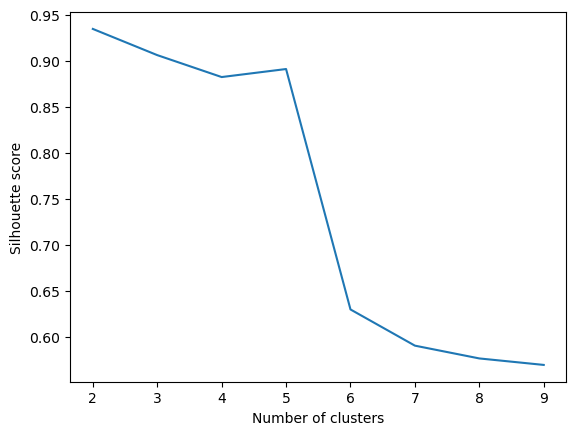

In [20]:
train_kmeans(clusters, df_user, 'Monetary', 'Silhouette score')

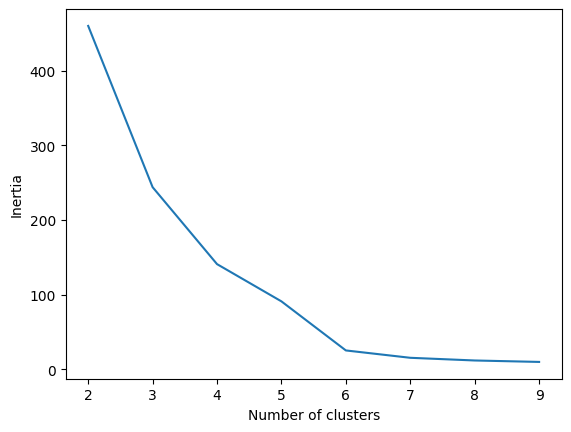

In [38]:
train_kmeans(clusters, df_user, 'Monetary', 'Inertia')

In [43]:
kmeans.fit(df_user[['Monetary']])
df_user['MonetaryCluster'] = kmeans.labels_
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,MonetaryCluster
0,CNTID_1000,17,3,4,2,7846,1
1,CNTID_1003,546,0,1,0,47,0
2,CNTID_1004,199,2,1,0,209,0
3,CNTID_1006,24,3,2,1,311,0
4,CNTID_1008,15,3,3,1,388,0


In [44]:
df_user = assign_score(df_user, 'Monetary','MonetaryCluster',ascending=True)
df_user.head()

,ContactId,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,new_MonetaryCluster
0,CNTID_1000,17,3,4,2,7846,3
1,CNTID_1003,546,0,1,0,47,0
2,CNTID_1004,199,2,1,0,209,0
3,CNTID_1006,24,3,2,1,311,0
4,CNTID_1008,15,3,3,1,388,0


### Overall Score

In [45]:
df_user[['new_RecencyCluster','new_FrequencyCluster','new_MonetaryCluster']] = df_user[['new_RecencyCluster','new_FrequencyCluster','new_MonetaryCluster']].apply(lambda x: x.astype(int), axis=1)
df_user['OverallScore'] = df_user['new_RecencyCluster'] + df_user['new_FrequencyCluster'] + df_user['new_MonetaryCluster']
df_user.groupby('OverallScore')[['Recency','Frequency','Monetary']].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,627.373188,1.000000,133.583333
1,427.703704,1.239057,173.164983
2,278.900474,1.627962,225.049763
3,158.908621,2.153448,357.286207
4,55.270127,2.762712,479.341102
5,32.883590,3.987377,707.927069
6,19.388967,4.917963,916.657709
7,74.000000,4.250000,5741.722222
8,46.404762,4.285714,7494.285714


In [46]:
df.drop(['CreatedOn','CreatedOn_loyalty','PurchaseId', 'ProductId', 'PurchasedOn', 'TotalPrice', 'City'], axis=1, inplace=True)
df_merged = pd.merge(df, df_user, on='ContactId').drop_duplicates()

In [47]:
df_merged['Segment'] = 'Low-Value'
df_merged.loc[df_merged['OverallScore'] > 2, 'Segment'] = 'Middle-Value'
df_merged.loc[df_merged['OverallScore'] > 5, 'Segment'] = 'High-Value'

In [31]:
df_merged.head()

,ContactId,Gender,State,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,ReviewRating,Age,Tenure,Days_since_first_purs,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,new_MonetaryCluster,OverallScore,Segment
0,CNTID_1000,Female,California,high,Yes,256414.112709,Software Engineer,high,293,Yes,4.800000,32,320,337,17,3,4,2,7846,3,8,High-Value
4,CNTID_1003,Male,Tennessee,medium,No,61917.706144,Teacher,medium,116,No,5.000000,12,1,547,546,0,1,0,47,0,0,Low-Value
5,CNTID_1004,Male,California,medium,No,20000.000000,Teacher,medium,249,No,3.333333,21,1,200,199,2,1,0,209,0,2,Low-Value
6,CNTID_1006,Male,Arizona,medium,No,49263.048955,Software Engineer,low,155,Yes,2.500000,2,81,105,24,3,2,1,311,0,4,Middle-Value
8,CNTID_1008,Male,California,medium,No,23242.992770,Teacher,medium,264,No,2.750000,21,80,95,15,3,3,1,388,0,4,Middle-Value


In [48]:
avg_freq = len(df)/df_merged.ContactId.nunique()
avg_lifespan = df_merged.Tenure.mean()

In [49]:
df_merged['CLV'] = df_merged.Monetary*avg_freq*avg_lifespan
df_merged.head()

,ContactId,Gender,State,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,ReviewRating,Age,Tenure,Days_since_first_purs,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,new_MonetaryCluster,OverallScore,Segment,CLV
0,CNTID_1000,Female,California,high,Yes,256414.112709,Software Engineer,high,293,Yes,4.800000,32,320,337,17,3,4,2,7846,3,8,High-Value,5.536246e+06
4,CNTID_1003,Male,Tennessee,medium,No,61917.706144,Teacher,medium,116,No,5.000000,12,1,547,546,0,1,0,47,0,0,Low-Value,3.316385e+04
5,CNTID_1004,Male,California,medium,No,20000.000000,Teacher,medium,249,No,3.333333,21,1,200,199,2,1,0,209,0,2,Low-Value,1.474733e+05
6,CNTID_1006,Male,Arizona,medium,No,49263.048955,Software Engineer,low,155,Yes,2.500000,2,81,105,24,3,2,1,311,0,4,Middle-Value,2.194459e+05
8,CNTID_1008,Male,California,medium,No,23242.992770,Teacher,medium,264,No,2.750000,21,80,95,15,3,3,1,388,0,4,Middle-Value,2.737782e+05


In [50]:
kmeans = KMeans(n_clusters=3, random_state=29)
kmeans.fit(df_merged[['CLV']])
df_merged['Cluster'] = kmeans.labels_

In [51]:
df_merged = assign_score(df_merged, 'CLV','Cluster',ascending=True)
df_merged.head()

,ContactId,Gender,State,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,ReviewRating,Age,Tenure,Days_since_first_purs,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,new_MonetaryCluster,OverallScore,Segment,CLV,new_Cluster
0,CNTID_1000,Female,California,high,Yes,256414.112709,Software Engineer,high,293,Yes,4.800000,32,320,337,17,3,4,2,7846,3,8,High-Value,5.536246e+06,2
4,CNTID_1003,Male,Tennessee,medium,No,61917.706144,Teacher,medium,116,No,5.000000,12,1,547,546,0,1,0,47,0,0,Low-Value,3.316385e+04,0
5,CNTID_1004,Male,California,medium,No,20000.000000,Teacher,medium,249,No,3.333333,21,1,200,199,2,1,0,209,0,2,Low-Value,1.474733e+05,0
6,CNTID_1006,Male,Arizona,medium,No,49263.048955,Software Engineer,low,155,Yes,2.500000,2,81,105,24,3,2,1,311,0,4,Middle-Value,2.194459e+05,0
8,CNTID_1008,Male,California,medium,No,23242.992770,Teacher,medium,264,No,2.750000,21,80,95,15,3,3,1,388,0,4,Middle-Value,2.737782e+05,0


In [30]:
df_merged.new_Cluster.value_counts(normalize=True)

new_Cluster
0    0.926231
1    0.038826
2    0.034943
Name: proportion, dtype: float64

In [52]:
df_merged[['new_RecencyCluster','new_FrequencyCluster','new_MonetaryCluster']] = df_merged[['new_RecencyCluster','new_FrequencyCluster','new_MonetaryCluster']].astype('object')

In [43]:
from sklearn.metrics import mutual_info_score

def mutual_score(var):
    return round(mutual_info_score(var, df_merged.new_Cluster), 5)
df_merged.drop(columns=['ContactId','State','CLV','new_Cluster','new_Cluster']).apply(mutual_score).sort_values(ascending=False)

Monetary                 0.31431
new_MonetaryCluster      0.31299
Income                   0.31271
OverallScore             0.18520
Days_since_first_purs    0.17707
Tenure                   0.14462
Recency                  0.08383
Loyalty Tier             0.07692
Email Subscriber         0.07465
Occupation               0.07383
RewardPoints             0.07355
Segment                  0.07283
Frequency                0.04994
new_FrequencyCluster     0.04957
new_RecencyCluster       0.02179
CustomerSatisfaction     0.01802
Age                      0.01561
ReviewRating             0.00672
CreditCard               0.00018
Gender                   0.00006
dtype: float64

In [53]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(df_merged.drop(['ContactId','State','CLV','new_Cluster','Monetary'], axis=1), df_merged.new_Cluster,
#                                                     test_size=0.8, random_state=29)

x_train, x_test, y_train, y_test = train_test_split(df_merged.drop(['ContactId','State','CLV', 'Monetary',
       'new_RecencyCluster', 'new_FrequencyCluster', 'new_MonetaryCluster','new_Cluster'], axis=1), 
       df_merged.new_Cluster, test_size=0.8, random_state=29)

In [54]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

def data_transformer():
    
    # num_columns = ['Income', 'ReviewRating', 'Recency', 'Frequency',
    #    'OverallScore']
    # cat_columns = ['Gender', 'Loyalty Tier', 'Email Subscriber', 'Occupation',
    #    'CustomerSatisfaction', 'CreditCard', 'new_RecencyCluster',
    #    'new_FrequencyCluster', 'new_MonetaryCluster', 'Segment']

    num_columns = ['Income', 'ReviewRating', 'Recency', 'Frequency',
       'OverallScore']
    cat_columns = ['Gender', 'Loyalty Tier', 'Email Subscriber', 'Occupation',
       'CustomerSatisfaction', 'CreditCard', 'Segment']
    
    num_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])
    cat_pipeline = Pipeline([
        ('ohe', OneHotEncoder(sparse_output=False, categories='auto')),
        ('scaler', StandardScaler())
    ])
    
    data_transformer = ColumnTransformer([
        ('num_pipeline', num_pipeline, num_columns),
        ('cat_pipeline', cat_pipeline, cat_columns)
    ])
    
    return data_transformer

In [55]:
transformer = data_transformer()
X_train = transformer.fit_transform(x_train)
X_test = transformer.transform(x_test)

# from sklearn.preprocessing import OrdinalEncoder

# order = ['Low-Value', 'Middle-Value','High-Value']
# ord_enc = OrdinalEncoder(categories=[order])
# y_train = ord_enc.fit_transform(y_train.to_numpy().reshape(-1, 1))
# y_test = ord_enc.transform(y_test.to_numpy().reshape(-1, 1))

In [56]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, learning_curve
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_curve

In [36]:
# pipeline with SMOTE oversampling
pipe_base = imbpipeline(steps=[
    ['oversampling', SMOTE(random_state=29, sampling_strategy = {'0':6181, '1':3090, '2': 3090})],
    ['scaler', StandardScaler()],
    ['classifier', LogisticRegression(random_state=29)]
], memory="cache_folder")

In [37]:
# grid of all base models
param_grid_base = [
    {'classifier': [LogisticRegression(multi_class='multinomial', max_iter=500, solver='lbfgs', random_state=29)]}, 
    {'classifier': [SGDClassifier(random_state=29)]},
    {'classifier': [SVC(random_state=29)]},
    {'classifier': [KNeighborsClassifier()]},
    {'classifier': [DecisionTreeClassifier(random_state=29)]},
    {'classifier': [RandomForestClassifier(random_state=29)]},
    {'classifier': [AdaBoostClassifier(random_state=29)]},
]

# scroing metrics
scoring = {
    'f1_weighted': 'f1_weighted'
    # 'recall': "recall(average='weighted')",
    # 'precision': "precision(average='weighted')",
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

In [38]:
base_grid = GridSearchCV(estimator = pipe_base, param_grid = param_grid_base, cv = cv, scoring=scoring, refit='f1_weighted', n_jobs = -1, return_train_score=True)

In [39]:
%time print(base_grid.fit(X_train, y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(memory='cache_folder',
                                steps=[['oversampling',
                                        SMOTE(random_state=29,
                                              sampling_strategy={'0': 6181,
                                                                 '1': 3090,
                                                                 '2': 3090})],
                                       ['scaler', StandardScaler()],
                                       ['classifier',
                                        LogisticRegression(random_state=29)]]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_i...
                         {'classifier': [SGDClassifier(random_state=29)]},
                         {'classifier': [SVC(random_state=29)]},
                         {'classifier': [KNeighborsClassifier()]},
                

In [42]:
print('Best estimator %s with f1_weighted = %.4f' % (base_grid.best_estimator_['classifier'], base_grid.best_score_))

Best estimator LogisticRegression(max_iter=500, multi_class='multinomial', random_state=29) with f1_weighted = 0.9840


In [48]:
base_grid_result = pd.DataFrame(base_grid.cv_results_).drop(columns=['params'])
base_grid_result['classifier_name'] = base_grid_result['param_classifier'].astype(str).str.replace(r"\(.*\)","")
base_grid_result[['rank_test_f1_weighted', 'classifier_name', 'mean_test_f1_weighted', 'std_test_f1_weighted', 'mean_train_f1_weighted', 'std_train_f1_weighted']].sort_values('rank_test_f1_weighted')

,rank_test_f1_weighted,classifier_name,mean_test_f1_weighted,std_test_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted
0,1,"LogisticRegression(max_iter=500, multi_class='...",0.983977,0.010565,0.993453,0.001466
5,2,RandomForestClassifier(random_state=29),0.981760,0.008803,1.000000,0.000000
2,3,SVC(random_state=29),0.974465,0.010675,0.999699,0.000602
4,4,DecisionTreeClassifier(random_state=29),0.969232,0.012026,1.000000,0.000000
1,5,SGDClassifier(random_state=29),0.966854,0.014794,0.982142,0.005587
3,6,KNeighborsClassifier(),0.937443,0.012354,1.000000,0.000000
6,7,AdaBoostClassifier(random_state=29),0.752243,0.077082,0.759353,0.077410


In [94]:
## params grid best
params_best = [
    {'classifier': [LogisticRegression(max_iter=500, multi_class='multinomial', random_state=29)], 'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.1, 0.5, 1]},
    {'classifier': [SGDClassifier(random_state=29)], 'classifier__penalty': ['l1', 'l2'], 'classifier__alpha': [0.001, 0.005, 0.01], 'classifier__learning_rate': ['constant', 'adaptive'], 'classifier__eta0': [0.01, 0.1]},
    {'classifier': [SVC(random_state=29)], 'classifier__kernel': ['rbf', 'poly'], 'classifier__degree': [2, 3], 'classifier__C': [0.5, 1, 1.5]},
    {'classifier': [KNeighborsClassifier()], 'classifier__n_neighbors': [3, 5, 7], 'classifier__p': [1, 2]},
    {'classifier': [DecisionTreeClassifier(random_state=29)], 'classifier__max_depth': [3, 5, 7], 'classifier__min_samples_split': [5, 10, 20], 'classifier__min_samples_leaf' : [5, 10, 20]},
    {'classifier': [RandomForestClassifier(random_state=29)], 'classifier__max_depth': [None, 3, 5, 7], 'classifier__min_samples_split': [5, 10, 20], 'classifier__min_samples_leaf' : [5, 10, 20], 'classifier__n_estimators': [2, 5, 10]},
    {'classifier': [AdaBoostClassifier(random_state=29)], 'classifier__learning_rate': [0.1, 1], 'classifier__n_estimators': [5, 10, 20]}
]

In [95]:
best_grid = GridSearchCV(estimator = pipe_base, param_grid = params_best, cv = cv, scoring=scoring, refit='f1_weighted', n_jobs = -1, return_train_score=True)
%time print(best_grid.fit(X_train, y_train))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=29, shuffle=True),
             estimator=Pipeline(memory='cache_folder',
                                steps=[['oversampling',
                                        SMOTE(random_state=29,
                                              sampling_strategy={'0': 6181,
                                                                 '1': 3090,
                                                                 '2': 3090})],
                                       ['scaler', StandardScaler()],
                                       ['classifier',
                                        LogisticRegression(random_state=29)]]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(max_i...
                          'classifier__max_depth': [None, 3, 5, 7],
                          'classifier__min_samples_leaf': [5, 10, 20],
                          'classifier__min_samples_split': [5, 10, 20],
            

In [96]:
print('Best estimator %s with f1_weighted = %.4f' % (best_grid.best_estimator_['classifier'], best_grid.best_score_))

Best estimator LogisticRegression(C=0.5, max_iter=500, multi_class='multinomial',
                   random_state=29) with f1_weighted = 0.9840


In [99]:
best_grid_result = pd.DataFrame(best_grid.cv_results_).drop(columns=['params'])
best_grid_result['classifier_name'] = best_grid_result['param_classifier'].astype(str).str.replace(r"\(.*\)","")
best_grid_result.sort_values('rank_test_f1_weighted')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier,param_classifier__C,param_classifier__penalty,param_classifier__alpha,param_classifier__eta0,param_classifier__learning_rate,param_classifier__degree,param_classifier__kernel,param_classifier__n_neighbors,param_classifier__p,param_classifier__max_depth,param_classifier__min_samples_leaf,param_classifier__min_samples_split,param_classifier__n_estimators,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted,split0_train_f1_weighted,split1_train_f1_weighted,split2_train_f1_weighted,split3_train_f1_weighted,split4_train_f1_weighted,mean_train_f1_weighted,std_train_f1_weighted,classifier_name
3,2.323692,0.093529,0.016184,0.004796,"LogisticRegression(max_iter=500, multi_class='...",0.5,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.977659,0.994131,0.987879,0.966509,0.993709,0.983977,0.010565,1,0.989526,0.992573,0.989752,0.994020,0.991170,0.991408,0.001704,"LogisticRegression(max_iter=500, multi_class='..."
5,2.155194,0.216856,0.014467,0.007035,"LogisticRegression(max_iter=500, multi_class='...",1,l2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.977659,0.994131,0.987879,0.966509,0.993709,0.983977,0.010565,1,0.994020,0.992573,0.994020,0.995482,0.991170,0.993453,0.001466,"LogisticRegression(max_iter=500, multi_class='..."
77,0.904866,0.119551,0.019553,0.011525,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,5,10,0.967680,0.993716,0.987053,0.987053,0.971703,0.981441,0.009979,3,0.995338,0.993807,0.995337,0.995337,0.995345,0.995033,0.000613,RandomForestClassifier(random_state=29)
80,0.526597,0.065254,0.020383,0.004111,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,10,10,0.967680,0.993716,0.987053,0.987053,0.971703,0.981441,0.009979,3,0.995338,0.993807,0.995337,0.995337,0.995345,0.995033,0.000613,RandomForestClassifier(random_state=29)
79,0.323110,0.014166,0.013217,0.006659,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,10,5,0.973383,0.971065,0.993747,0.987053,0.979686,0.980987,0.008457,5,0.992229,0.990574,0.993731,0.992197,0.990711,0.991889,0.001159,RandomForestClassifier(random_state=29)
76,0.674621,0.094743,0.023802,0.010928,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,5,5,0.973383,0.971065,0.993747,0.987053,0.979686,0.980987,0.008457,5,0.992229,0.990574,0.993731,0.992197,0.990711,0.991889,0.001159,RandomForestClassifier(random_state=29)
82,0.326681,0.013756,0.008945,0.001470,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,5,20,5,0.965467,0.993716,0.981242,0.987053,0.971703,0.979836,0.010191,7,0.993731,0.988756,0.993803,0.990563,0.993824,0.992135,0.002101,RandomForestClassifier(random_state=29)
86,1.205264,0.097739,0.025455,0.008766,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10,5,10,0.948287,0.993716,0.987053,0.980035,0.986974,0.979213,0.016057,8,0.990430,0.990574,0.993803,0.990563,0.990765,0.991227,0.001292,RandomForestClassifier(random_state=29)
89,0.723337,0.055993,0.015049,0.011303,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10,10,10,0.948287,0.993716,0.987053,0.980035,0.986974,0.979213,0.016057,8,0.990430,0.990574,0.993803,0.990563,0.990765,0.991227,0.001292,RandomForestClassifier(random_state=29)
92,0.993409,0.238512,0.021090,0.007459,RandomForestClassifier(random_state=29),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,10,20,10,0.948287,0.993716,0.987053,0.980035,0.986974,0.979213,0.016057,8,0.990430,0.990574,0.993803,0.990563,0.990765,0.991227,0.001292,RandomForestClassifier(random_state=29)


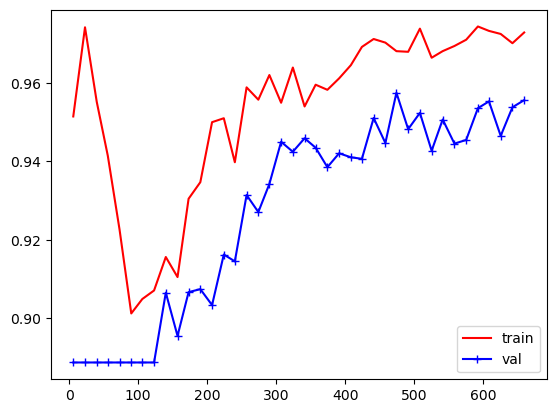

In [100]:
train_size, train_score, val_score = learning_curve(RandomForestClassifier(n_estimators=10, min_samples_leaf=5, min_samples_split=5), X_train, y_train, 
                        train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='f1_weighted')

train_score = np.mean(train_score, axis=1)
val_score = np.mean(val_score, axis=1)

plt.plot(train_size, train_score, 'r-', label='train')
plt.plot(train_size, val_score, 'b-+', label='val')
plt.legend()

plt.show()

In [59]:
logis_clf = LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
logis_clf.fit(X_train, y_train)
y_pred = logis_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3055
           1       0.84      0.81      0.83       121
           2       0.92      0.91      0.91       121

    accuracy                           0.99      3297
   macro avg       0.92      0.91      0.91      3297
weighted avg       0.99      0.99      0.99      3297



In [102]:
rf_clf = RandomForestClassifier(n_estimators=10, min_samples_leaf=5, min_samples_split=5)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, y_pred))
                       

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3055
           1       0.81      0.56      0.66       121
           2       0.90      0.85      0.87       121

    accuracy                           0.98      3297
   macro avg       0.90      0.80      0.84      3297
weighted avg       0.97      0.98      0.97      3297



In [103]:
feature_names_out = transformer.get_feature_names_out()

# Combine feature names with coefficients
coef_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': logis_clf.coef_[0]})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(coef_df_sorted[:10])

                                       Feature  Coefficient  Abs_Coefficient
4                   num_pipeline__OverallScore    -3.105661         3.105661
2                        num_pipeline__Recency    -1.419599         1.419599
3                      num_pipeline__Frequency     1.236584         1.236584
23             cat_pipeline__Segment_Low-Value     0.861792         0.861792
0                         num_pipeline__Income    -0.853757         0.853757
22            cat_pipeline__Segment_High-Value    -0.441379         0.441379
24          cat_pipeline__Segment_Middle-Value    -0.386623         0.386623
7              cat_pipeline__Loyalty Tier_high    -0.324769         0.324769
16            cat_pipeline__Occupation_Teacher     0.210283         0.210283
14  cat_pipeline__Occupation_Software Engineer    -0.197741         0.197741


In [104]:
# Combine feature names with coefficients
coef_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': logis_clf.coef_[1]})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(coef_df_sorted[:10])

                               Feature  Coefficient  Abs_Coefficient
2                num_pipeline__Recency     1.636563         1.636563
3              num_pipeline__Frequency    -1.508777         1.508777
23     cat_pipeline__Segment_Low-Value    -0.861734         0.861734
4           num_pipeline__OverallScore     0.731598         0.731598
24  cat_pipeline__Segment_Middle-Value     0.529078         0.529078
22    cat_pipeline__Segment_High-Value     0.266726         0.266726
10   cat_pipeline__Email Subscriber_No    -0.261805         0.261805
11  cat_pipeline__Email Subscriber_Yes     0.261805         0.261805
9    cat_pipeline__Loyalty Tier_medium    -0.244609         0.244609
12     cat_pipeline__Occupation_Doctor    -0.232743         0.232743


In [105]:
# Combine feature names with coefficients
coef_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': logis_clf.coef_[2]})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(coef_df_sorted[:10])

                                   Feature  Coefficient  Abs_Coefficient
4               num_pipeline__OverallScore     2.374063         2.374063
0                     num_pipeline__Income     0.778582         0.778582
8           cat_pipeline__Loyalty Tier_low    -0.370915         0.370915
3                  num_pipeline__Frequency     0.272193         0.272193
12         cat_pipeline__Occupation_Doctor     0.248603         0.248603
18  cat_pipeline__CustomerSatisfaction_low     0.240796         0.240796
7          cat_pipeline__Loyalty Tier_high     0.234394         0.234394
1               num_pipeline__ReviewRating     0.231602         0.231602
2                    num_pipeline__Recency    -0.216965         0.216965
16        cat_pipeline__Occupation_Teacher    -0.209466         0.209466


In [61]:
df_merged.head()

,ContactId,Gender,State,Loyalty Tier,Email Subscriber,Income,Occupation,CustomerSatisfaction,RewardPoints,CreditCard,ReviewRating,Age,Tenure,Days_since_first_purs,Recency,new_RecencyCluster,Frequency,new_FrequencyCluster,Monetary,new_MonetaryCluster,OverallScore,Segment,CLV,new_Cluster
0,CNTID_1000,Female,California,high,Yes,256414.112709,Software Engineer,high,293,Yes,4.800000,32,320,337,17,3,4,2,7846,3,8,High-Value,5.536246e+06,2
4,CNTID_1003,Male,Tennessee,medium,No,61917.706144,Teacher,medium,116,No,5.000000,12,1,547,546,0,1,0,47,0,0,Low-Value,3.316385e+04,0
5,CNTID_1004,Male,California,medium,No,20000.000000,Teacher,medium,249,No,3.333333,21,1,200,199,2,1,0,209,0,2,Low-Value,1.474733e+05,0
6,CNTID_1006,Male,Arizona,medium,No,49263.048955,Software Engineer,low,155,Yes,2.500000,2,81,105,24,3,2,1,311,0,4,Middle-Value,2.194459e+05,0
8,CNTID_1008,Male,California,medium,No,23242.992770,Teacher,medium,264,No,2.750000,21,80,95,15,3,3,1,388,0,4,Middle-Value,2.737782e+05,0


In [81]:
pd.crosstab(df_merged[cat_features[1]], df_merged['new_Cluster'])

new_Cluster,0,1,2
Loyalty Tier,,,
high,269,85,89
low,370,49,29
medium,3178,26,26


In [71]:
cat_features = ['Gender', 'Loyalty Tier', 'Email Subscriber',
       'Occupation', 'CustomerSatisfaction', 'CreditCard',
       'new_RecencyCluster', 'new_FrequencyCluster', 'new_MonetaryCluster',
       'Segment']
palette = {'0' : '#228B22', '1':'#85c985', '2' : '#595959'}

In [84]:
df_merged['new_Cluster'] = pd.Categorical(df_merged['new_Cluster'], ['0','1','2'])

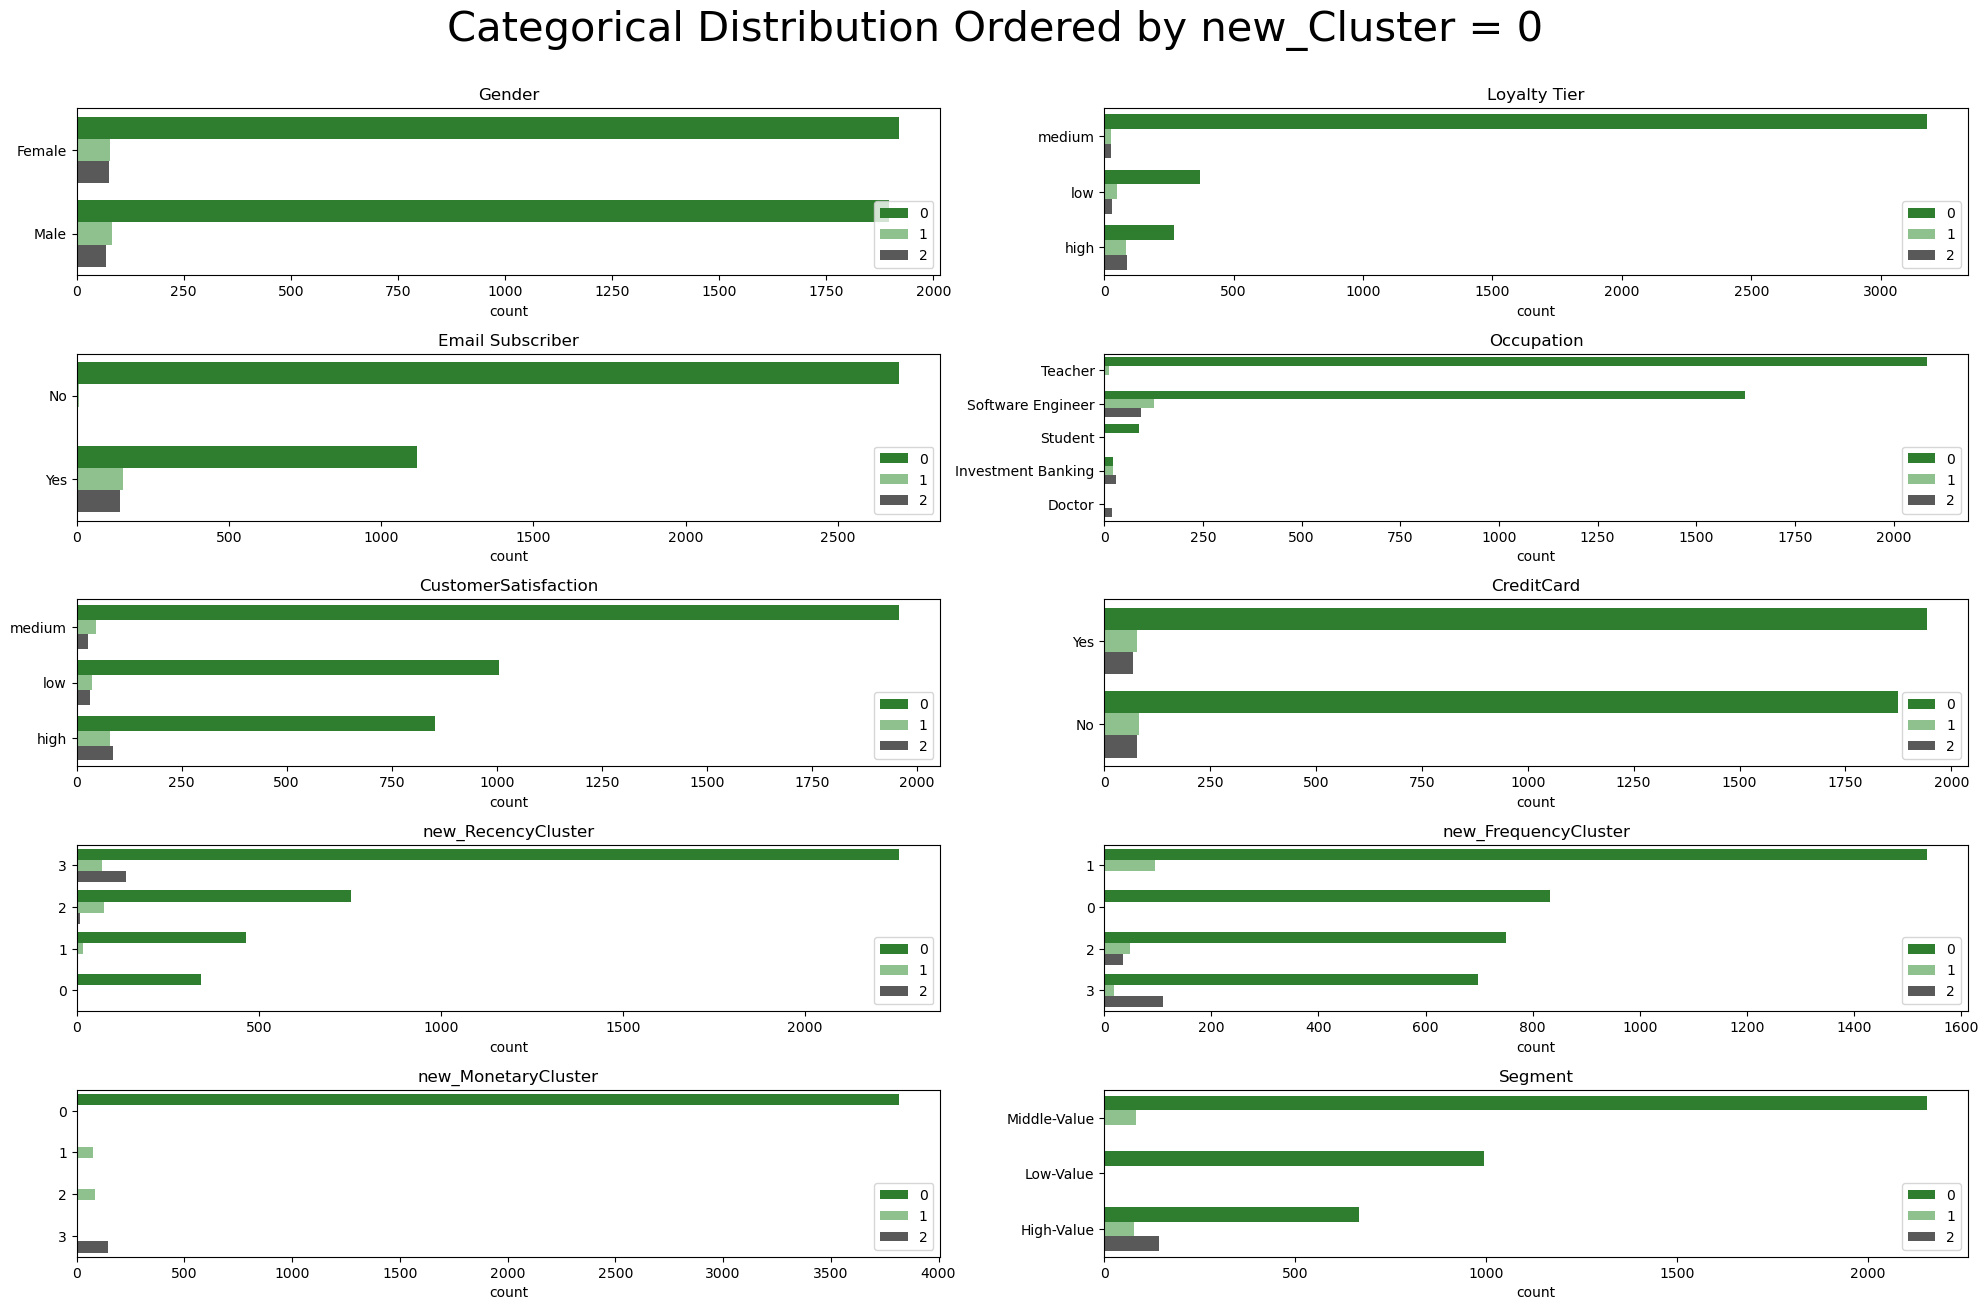

In [97]:
plt.figure(figsize=(20, 15))
plt.suptitle('Categorical Distribution Ordered by new_Cluster = 0', fontsize=30, y = 1.005)
for i in range(len(cat_features)):
    plt.subplot(len(cat_features)//2+1, 2, i+1)
    ax = sns.countplot(
        y = df_merged[cat_features[i]], palette = palette, order = pd.crosstab(df_merged[cat_features[i]], df_merged['new_Cluster']).sort_values(by='0', ascending = False).index,
        hue = df_merged['new_Cluster']
    )
    ax.set_ylabel('')
    ax.set_title(cat_features[i])
    
    # for p in ax.patches:
    #     ax.annotate(
    #         format(p.get_width(), '.0f'),
    #         (p.get_width(), p.get_y() + p.get_height() / 2.), 
    #         ha = 'left',
    #         fontweight = "bold",
    #         xytext = (5,-5), 
    #         textcoords = 'offset points',
    #         color = 'gray', fontsize=14
    #     )
    # handles, labels = plt.gca().get_legend_handles_labels()
    # order = [1,2,0]
    # plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 
    ax.legend(loc='lower right')
plt.tight_layout()

plt.savefig('../images/clv_cat.png')
plt.show()

In [91]:
num_features = df_merged.select_dtypes(['int64','float64']).columns

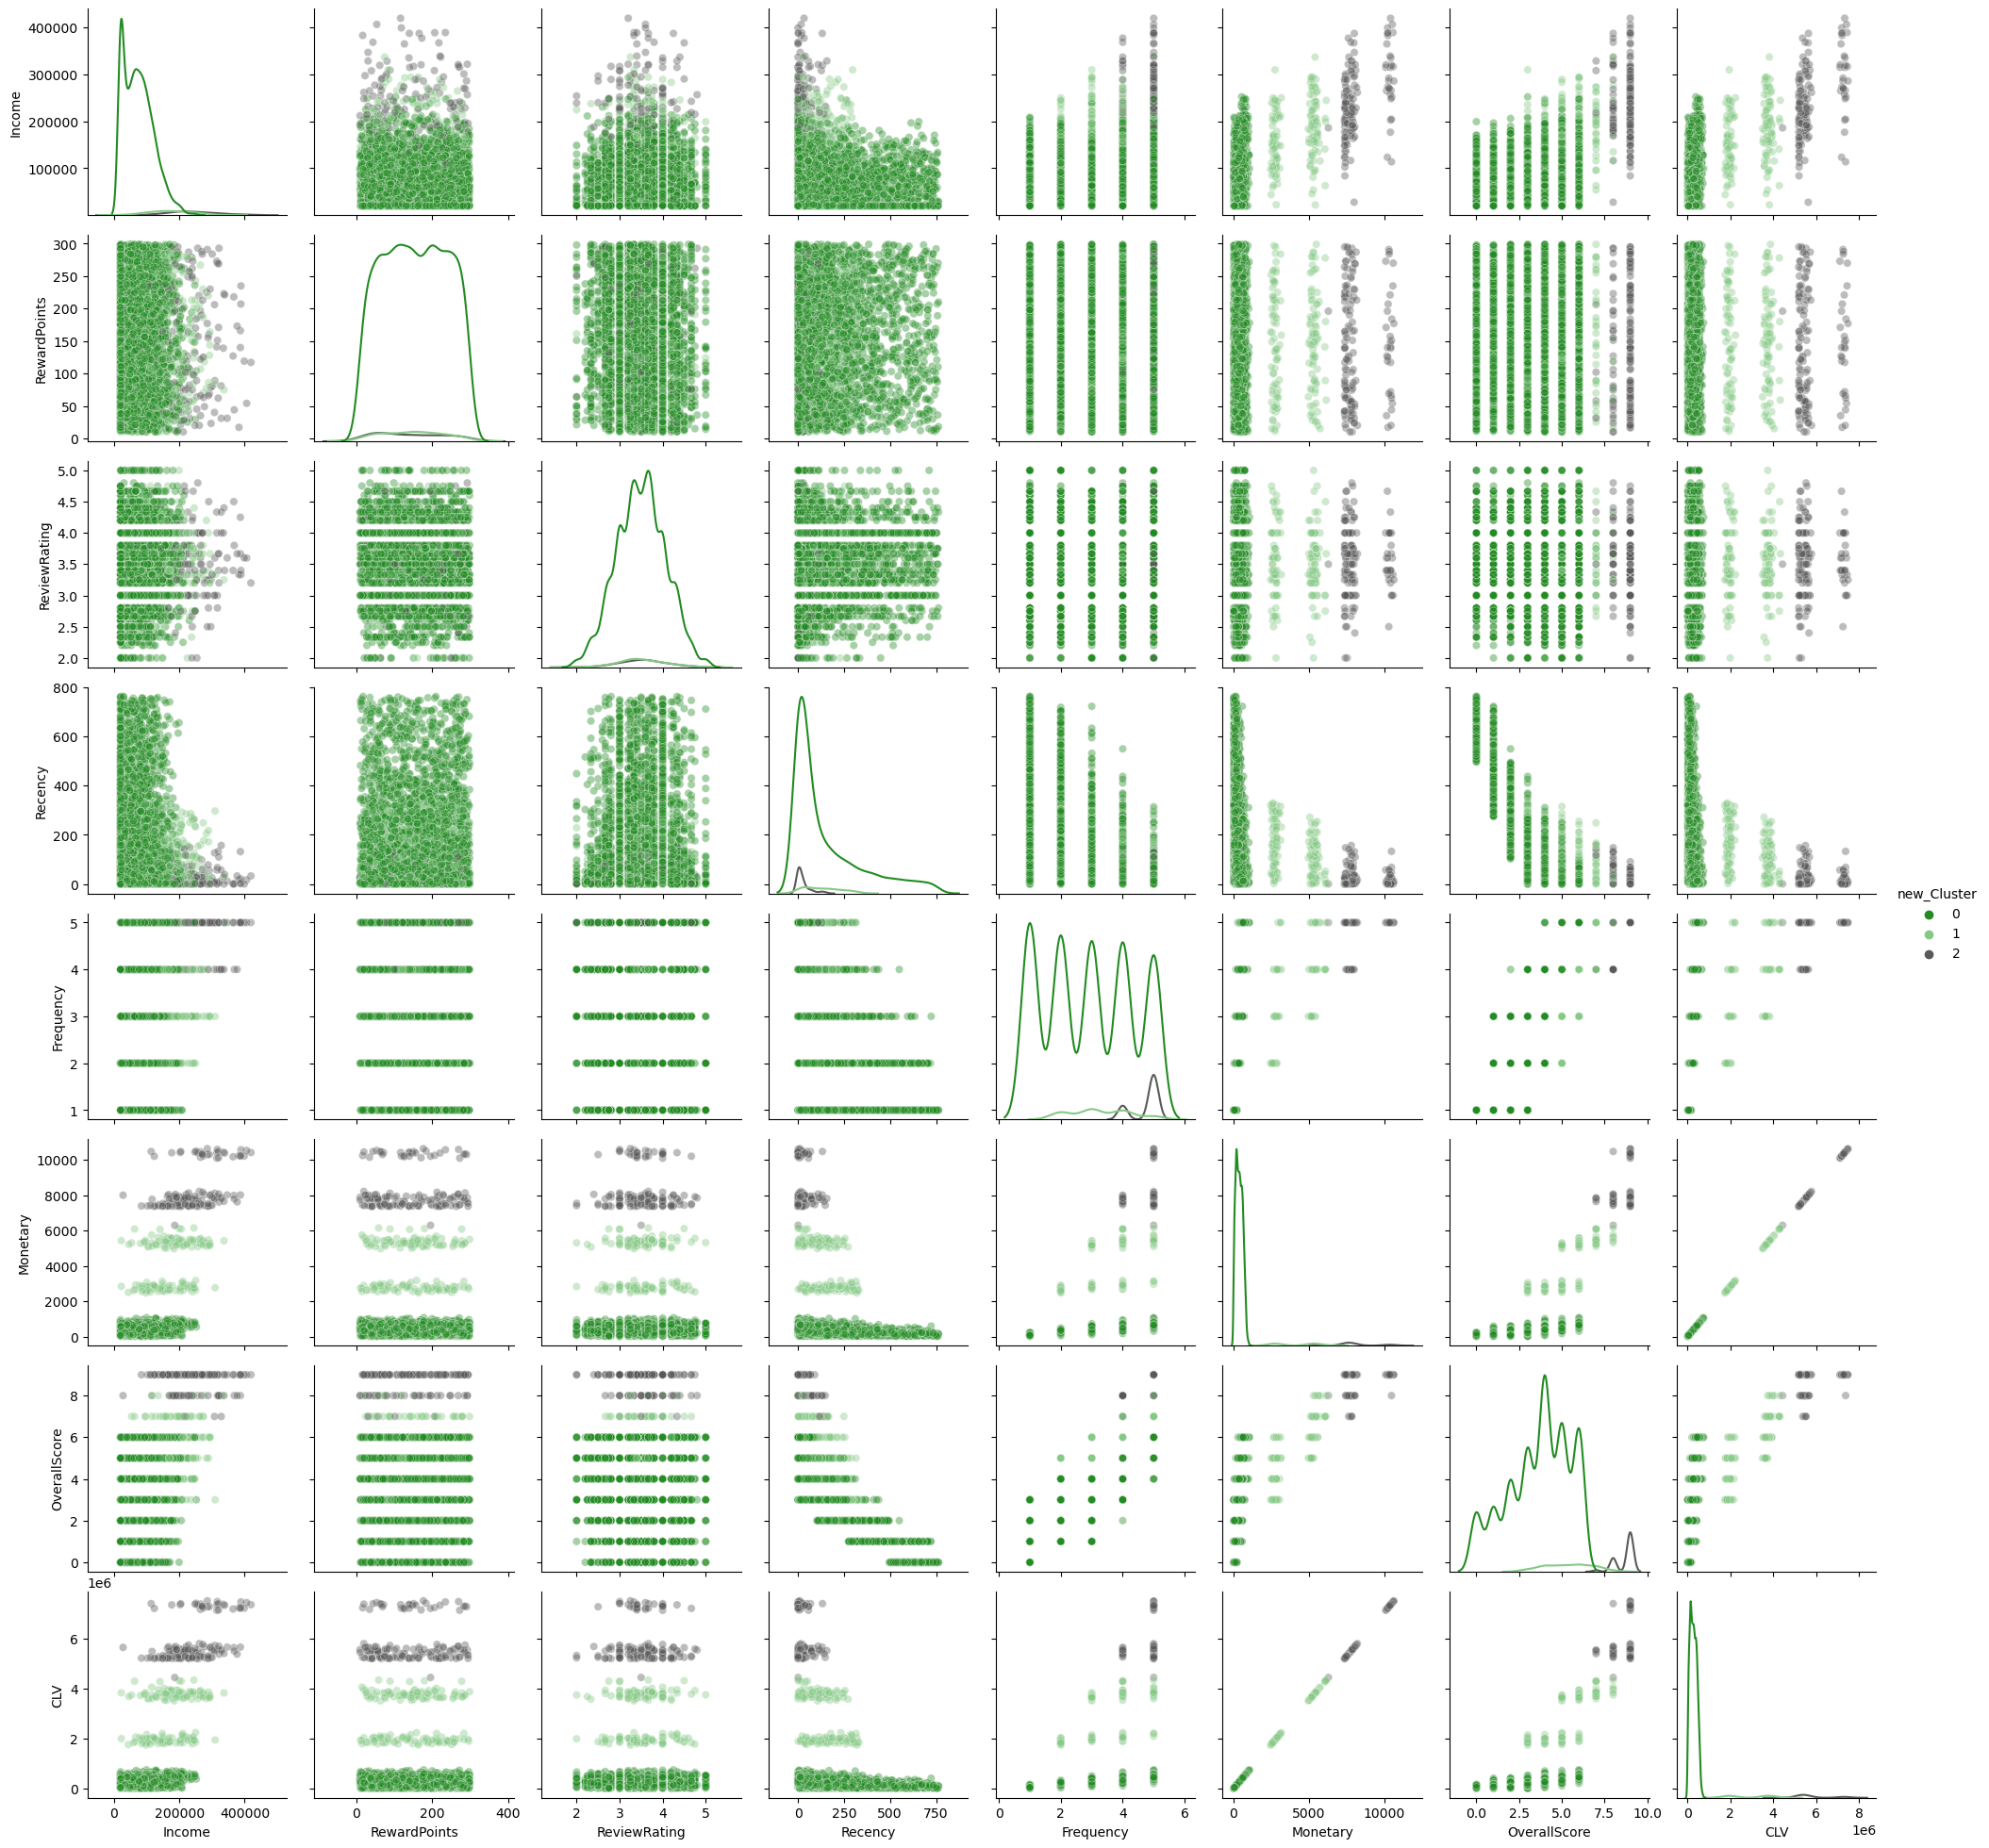

In [95]:
grid = sns.PairGrid(df_merged[num_features.append(pd.Index(['new_Cluster']))], hue='new_Cluster', palette=palette,
                    diag_sharey=False)

grid.map_offdiag(sns.scatterplot, alpha=0.4)
grid.map_diag(sns.kdeplot)
grid.add_legend()

plt.savefig('../images/clv_num.png')
plt.show()